<a href="https://colab.research.google.com/github/Sunn2x333/scalar_framework/blob/main/scalarcmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving PDE...
Gradient stats: Mean=8.90e-11, Max=4.38e-10, Min=6.35e-14


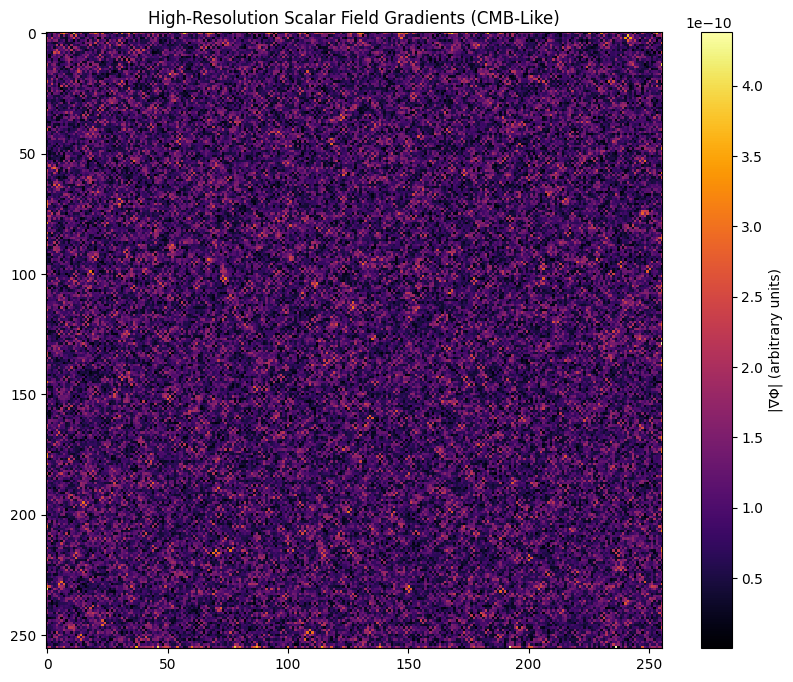

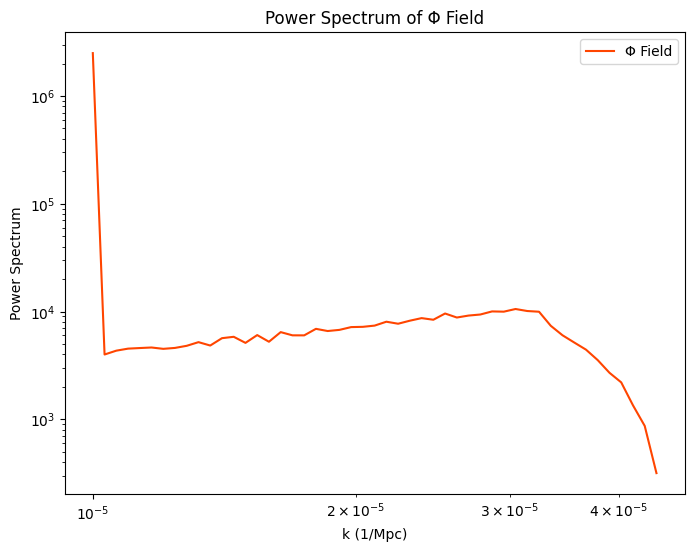

Runtime: 7.63 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fft import fft2, fftfreq
import time
import sys

# Error handling for Colab environment
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %matplotlib inline

# Start timing
start_time = time.time()

# Configurable parameters at the top (reduce manual edits)
N = 256  # Grid size (increase for higher res; 256 safe, 512 possible)
dx = 1e5  # Spatial step (0.1 Mpc)
dt = 0.0001  # Time step
t_end = 0.1  # Evolution end time
ns = 0.968  # Power spectrum index (CMB-like)
fluctuation_scale = 1e-5  # CMB-like delta Phi/Phi
k = 1.0  # Wave coefficient
K_prime_prime = 0.01  # Nonlinear coefficient (scaled)
lambda_coeff = 0.01  # Linear term
damping = 0.1  # Damping factor
use_seed = False  # Set to True for reproducibility (reduces variability error)
seed_value = 42  # Seed if use_seed=True

# Memory check (to prevent crashes)
if N > 512:
    print("Warning: N > 512 may exceed memory limits on free Colab. Reducing to 512.")
    N = 512

L = dx * N  # Physical size

# Set seed if desired
if use_seed:
    np.random.seed(seed_value)

# CMB-like initial condition
def generate_cmb_field(N, ns=0.968):
    k = fftfreq(N, d=dx) * 2 * np.pi
    kx, ky = np.meshgrid(k, k)
    k_mag = np.sqrt(kx**2 + ky**2 + 1e-10)
    power = k_mag**(-ns)
    phase = np.random.uniform(0, 2*np.pi, (N, N))
    field = np.abs(np.fft.ifft2(np.sqrt(power) * np.exp(1j * phase)))
    return field / field.std() * fluctuation_scale

Phi_0 = generate_cmb_field(N, ns=ns)

# Laplacian with periodic boundaries
def laplacian_2d(grid):
    lap = (np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
           np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1) - 4 * grid) / dx**2
    return lap

# PDE for odeint
def pde(state, t, N):
    Phi = state[:N*N].reshape(N, N)
    dPhi_dt = state[N*N:].reshape(N, N)
    d2Phi_dt2 = (laplacian_2d(Phi) - K_prime_prime * Phi**3 - lambda_coeff * Phi -
                 damping * dPhi_dt) * k
    return np.concatenate([dPhi_dt.flatten(), d2Phi_dt2.flatten()])

# Initial conditions
state0 = np.concatenate([Phi_0.flatten(), np.zeros(N*N)])

# Time points
t = np.arange(0, t_end, dt)

# Solve PDE with error handling
print("Solving PDE...")
try:
    solution = odeint(pde, state0, t, args=(N,), rtol=1e-6, atol=1e-6)
    Phi_final = solution[-1, :N*N].reshape(N, N)
except Exception as e:
    print(f"Error during integration: {e}")
    print("Try reducing dt or increasing damping.")
    sys.exit(1)

# Compute gradients with NaN check
gradients = np.gradient(Phi_final, dx)
grad_mag = np.sqrt(gradients[0]**2 + gradients[1]**2)
if np.any(np.isnan(grad_mag)):
    print("Warning: NaNs detected in gradients. Simulation may be unstable.")

# Print stats
print(f"Gradient stats: Mean={np.mean(grad_mag):.2e}, Max={np.max(grad_mag):.2e}, Min={np.min(grad_mag):.2e}")

# Plot gradients
plt.figure(figsize=(10, 8))
plt.imshow(grad_mag, cmap='inferno', interpolation='nearest')
plt.colorbar(label='|∇Φ| (arbitrary units)')
plt.title('High-Resolution Scalar Field Gradients (CMB-Like)')
plt.savefig('high_res_gradients.png', dpi=300)
plt.show()

# Power spectrum
fft_field = fft2(Phi_final)
k = fftfreq(N, d=dx) * 2 * np.pi
k_mag = np.sqrt(k[:, None]**2 + k[None, :]**2 + 1e-10)
power_spectrum = np.abs(fft_field)**2
k_bins = np.logspace(np.log10(k_mag[k_mag > 0].min()), np.log10(k_mag.max()), 50)
hist, _ = np.histogram(k_mag, bins=k_bins, weights=power_spectrum, density=True)
power_binned = hist

# Plot power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(k_bins[:-1], power_binned, label='Φ Field', color='#ff4500')
plt.xlabel('k (1/Mpc)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum of Φ Field')
plt.legend()
plt.savefig('power_spectrum.png', dpi=300)
plt.show()

# Print runtime
print(f"Runtime: {time.time() - start_time:.2f} seconds")